手法の補足
- データ期間: 2025/01/01 00:00 - 2025/02/01 00:00 1分足
  - Tardisから取得し，1分足にするコードセルがありますが，これで作成したデータを共有しているので，その章のセルは実行不要です．
  - 精度向上のために，今後はそもそも1分足ではなく秒足やtickを使う可能性が高い．
- 取引戦略
  - `pred_steps=10` 分ごとに，1分先の板情報予測を自己回帰的に10回繰り返して10分先まで予測
  - 現在価格からの変化率が往復手数料率(2*0.055%)を上回るなら，成行注文
  - すでに買い(売り)ポジションを持っており，買い(売り)予測が続く場合は何もしない (ポジション保持)
- 取引はすべて成行で行う．
  - ⚠️指値のほうが手数料は安いが，上昇(下落)予測時に現在価格の少し下(上)に指値を出す戦略だと，実際には刺さらず機会損失になることがかなり多いため，成行を前提とし，モデルの精度を上げて上から殴る方針．

💡現在の改良案
- 📊データ関連
  - 🌟秒足・Tickデータを使う
    - そもそも板情報は一瞬の動きが重要なので．
    - ここで使うモデルは観測が一定時間間隔で行われる前提であり，tickデータのような不規則間隔への対応は工夫が必要．
      - 間隔自体もポアソン過程などで確率モデル化するアイディアはある．
  - 🌟Imbalance (価格帯ごとの合計数量のヒストグラム) を使う
  - データスケーリング方法
    - 現在 DeepLOB (Zhang+, 2019) と同様に，price/amountそれぞれ直近一定期間のμ,σで標準化している．
    - しかしamountに関しては，本来取る範囲が正であることと，Bybitでは注文数量制限(1度の指値注文で155BTCなど)があるので，それを目安に1000で除算するなどのほうが良いかも．データ間でスケールも統一される．
  - 板のスナップショットではなく注文データを使う (市場参加者の行動モデル)
    - 本来市場参加者の指値・成行注文が板のスナップショットを形成する．
    - これらの注文データを予測できれば，理論上は価格予測も可能なうえ，市場参加者のモデル化という意味も持つ．
    - Tardisからは `data_types` に指値なら `incremental_book_L2`，成行なら `trades` を指定してDL可能
    - 確率モデルとして実装するには分布設定(制約)がかなり複雑．
- 🧠モデル関連
  - ニューラルネットワークモデルの改良
    - 現在はシンプルな中間層2層のMLP (+dropoutによるモンテカルロサンプリング)
    - 1時刻に観測するデータはその時刻の板スナップショット (10レベルで40変数) のベクトル
    - 内部状態として複数の潜在変数ベクトル (つまり行列) で分布サンプルを表現している
      - これを効果的に扱えるようにネットワーク構造を工夫する余地あり (Transformerなど)
  - ハイパーパラメータ調整について
    - このモデルは良いパラメータを見つけられれば単調に増え続けるので，全データ期間で最適化したハイパラは今後も通用する可能性は高い．
    - これまでのところ，Optunaで最適化したが，手数料ありでも安定したパラメータは見つかっていない．

In [1]:
import tardis, backtest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import optuna, joblib, gc
import torch, time
import torch.nn.functional as F
from torch import nn, Tensor

LOB_DEPTH = 10  # 使用する板の深さ
B1_INDEX = 0                # B1のインデックス
A1_INDEX = 2 * LOB_DEPTH    # A1のインデックス
FEATURES = 4 * LOB_DEPTH    # 入力変数の数
BID, ASK, STAY = 0, 1, 2    # 行動ラベル: 売，買，何もしない
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データ取得・1分足保存
- データ期間: 2025/01/01 00:00 - 2025/02/01 00:00
- このコードで作成したCSVを共有しているので，**この章のセルは実行しなくてOK**です(数十分かかります)．
- ⚠️精度向上のために，今後は秒足やtickデータを使う方向にシフトする予定です．

In [2]:
# Tardisからダウンロード
DATA_DIR = "./data/tardis/daily"   # Tardisデータ保存先
tardis.download_data("2025-02-01", "2025-02-27", data_types=["book_snapshot_25"], download_dir=DATA_DIR)

In [3]:
# # 1分足にダウンサンプリングして読み込み
df_ss = tardis.load_snapshots("2025-02-01", "2025-02-27", DATA_DIR, freq="1min")

loading 2025-02-27 snapshot...


In [4]:
df_ss.to_csv(f"./BTCUSDT_book_2502_1min.csv.gz")

# 1分足データ読み込み

In [5]:
df_ss_jan = pd.read_csv(f"./BTCUSDT_book_2501_1min.csv.gz", index_col=0, parse_dates=True).ffill()
df_ss_feb = pd.read_csv(f"./BTCUSDT_book_2502_1min.csv.gz", index_col=0, parse_dates=True).ffill()
df_ss = pd.concat([df_ss_jan, df_ss_feb])
cols = (
    [f"b{i+1}"  for i in range(LOB_DEPTH)] +
    [f"bq{i+1}" for i in range(LOB_DEPTH)] +
    [f"a{i+1}"  for i in range(LOB_DEPTH)] +
    [f"aq{i+1}" for i in range(LOB_DEPTH)]
)
df_ss = df_ss[cols]

print(df_ss.index.is_monotonic_increasing)  # ✅️時刻は単調増加
print(df_ss.index.has_duplicates)           # ✅️時刻重複なし
print(df_ss.isna().sum().sum())             # ✅️欠損なし

True
False
0


In [6]:
df_ss

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,aq1,aq2,aq3,aq4,aq5,aq6,aq7,aq8,aq9,aq10
local_timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:01:00,93590.4,93590.0,93588.7,93588.4,93587.9,93587.8,93586.8,93586.6,93586.5,93586.3,...,1.042,0.488,0.412,0.050,0.002,0.026,0.054,0.009,0.053,0.001
2025-01-01 00:02:00,93625.0,93624.0,93623.4,93622.4,93621.5,93620.8,93620.7,93620.6,93620.3,93620.2,...,0.620,0.001,0.001,0.001,0.344,0.387,0.001,0.001,0.001,0.011
2025-01-01 00:03:00,93672.7,93672.6,93671.2,93670.9,93670.5,93670.3,93670.0,93669.3,93668.9,93668.4,...,1.033,0.294,0.004,0.001,0.002,0.002,0.094,0.001,0.002,0.004
2025-01-01 00:04:00,93649.9,93649.6,93649.1,93648.9,93648.8,93648.7,93647.8,93647.3,93646.8,93646.4,...,0.835,0.021,0.001,0.001,0.001,0.001,0.001,0.001,0.086,0.001
2025-01-01 00:05:00,93630.0,93629.7,93629.2,93629.0,93628.5,93628.1,93627.1,93626.2,93625.9,93625.8,...,0.483,0.095,0.214,0.005,0.011,0.012,0.001,0.003,0.003,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-27 23:56:00,84796.2,84796.0,84795.2,84794.3,84793.5,84793.4,84792.7,84792.6,84792.5,84792.4,...,3.189,0.354,0.047,0.588,0.094,0.591,0.569,0.002,0.047,0.047
2025-02-27 23:57:00,84831.5,84830.6,84830.1,84830.0,84829.8,84829.5,84829.2,84828.9,84828.1,84827.2,...,2.561,0.001,0.008,0.047,0.002,0.109,0.160,0.012,0.002,0.057
2025-02-27 23:58:00,84778.9,84778.4,84778.0,84777.0,84776.8,84776.4,84776.0,84775.8,84775.6,84775.3,...,0.019,0.002,0.002,0.012,0.002,0.002,0.002,0.001,0.032,0.104


# モデル

In [7]:
# 標準化: DeepLOB (Zhang+, 2019) ベース．サンプルごとに，価格と数量を別々に標準化 (バッチ処理にも1時刻にも対応)
class LOBScaler:
    def __init__(self, x: Tensor):              # x.shape: ((bsz), seqlen, 4*LOB_DEPTH) スケール基準データ
        self.depth = x.shape[-1] // 4
        x_ = x.contiguous().view(-1, 2*x.shape[-2], 2*self.depth)   # (bsz, 2*seqlen, 2*LOB_DEPTH) ※2次元配列の左半分(d列)をprice，右半分(d列)をamountにする
        self.price_mean  = x_[..., :self.depth].mean((1, 2), keepdim=True)      # (bsz, 1, 1)
        self.price_std   = x_[..., :self.depth].std( (1, 2), keepdim=True)      # (bsz, 1, 1)
        self.amount_mean = x_[..., self.depth:].mean((1, 2), keepdim=True)      # (bsz, 1, 1)
        self.amount_std  = x_[..., self.depth:].std( (1, 2), keepdim=True)      # (bsz, 1, 1)

    def normalize(self, x: Tensor):             # ((bsz), seqlen, 4*LOB_DEPTH)
        x_ = x.contiguous().view(-1, 2*x.shape[-2], 2*self.depth)               # (bsz, 2*seqlen, 2*LOB_DEPTH)
        price = (x_[..., :self.depth] - self.price_mean) / self.price_std       # (bsz, 2*seqlen, LOB_DEPTH)
        amount = (x_[..., self.depth:] - self.amount_mean) / self.amount_std    # (bsz, 2*seqlen, LOB_DEPTH)
        return torch.cat([price, amount], dim=-1).view_as(x)

    def denormalize(self, x_norm: Tensor):      # ((bsz), seqlen, 4*LOB_DEPTH)
        x_ = x_norm.contiguous().view(-1, 2*x_norm.shape[-2], 2*self.depth)     # (bsz, 2*seqlen, 2*LOB_DEPTH)
        price = x_[..., :self.depth] * self.price_std + self.price_mean         # (bsz, 2*seqlen, LOB_DEPTH)
        amount = x_[..., self.depth:] * self.amount_std + self.amount_mean      # (bsz, 2*seqlen, LOB_DEPTH)
        return torch.cat([price, amount], dim=-1).view_as(x_norm)

In [8]:
# カーネル密度推定によるサンプル群からの確率密度推定・KLD計算
def kde_log_density(x, y, bandwidth):   # (M, D), (N, D) -> (N,)
    norm2 = ((x[:, None] - y[None])**2).sum(-1) # (M, N)
    K = (-norm2 / (2 * bandwidth**2)).exp()     # (M, N)
    density = K.mean(-1) + 1e-8                 # (M,)
    return density.log()

def kld_kde(zq, zp, bandwidth=1):       # (M, D), (N, D) -> float
    lnq = kde_log_density(zq, zq, bandwidth)    # ln q(zq_i)
    lnp = kde_log_density(zq, zp, bandwidth)    # ln p(zq_i)
    return (lnq - lnp).mean()   # MC期待値

# encoder/decoder/transitionネットワークで共通のアーキテクチャ (dropoutによるMCサンプリング) 💡改良余地あり
class MCDropout(nn.Module):
    def __init__(self, in_dim, out_dim, dim, dropout=0.5):
        super().__init__()
        self.p = dropout
        self.in_fc = nn.Linear(in_dim, dim)
        self.out_fc = nn.Linear(dim, out_dim)

    def forward(self, x: Tensor):   # (bsz, dim)
        x = self.in_fc(x)
        x = F.dropout(x, self.p, training=True) # 推論時も常にdropoutすることでMCサンプリング
        x = self.out_fc(x)
        return x

# モデル本体
class FEP(nn.Module):
    def __init__(self, in_dim=40, dim=512, dropout=0.3, bsz=8):
        super().__init__()
        self.dim = dim
        self.bsz = bsz # モンテカルロサンプル数 (bsz個の世界線を持っている)
        self.encoder = MCDropout(in_dim+dim, dim, dim, dropout)
        self.decoder = MCDropout(dim, in_dim, dim, dropout)
        self.transition = MCDropout(dim, dim, dim, dropout)
        self.Qzt_prev = torch.randn((bsz, dim), device=DEVICE)
        self.xt = torch.zeros((bsz, in_dim), device=DEVICE)

    def forward(self, xt: Tensor) -> tuple[Tensor]: # (1, in_dim) ⚠️毎時刻1回実行される前提
        xt = xt.tile((self.bsz, 1))                 # (bsz, in_dim) x[t] の複製
        Pzt = self.transition(self.Qzt_prev)        # (bsz, dim)
        Qzt = self.encoder(torch.hstack([xt, Pzt])) # (bsz, dim)
        xt_prior = self.decoder(Qzt)                # (bsz, in_dim)
        uncertainty = (xt_prior - xt).pow(2).mean()
        complexity = kld_kde(Qzt, Pzt)
        self.xt = xt
        return uncertainty, complexity

    @torch.no_grad()
    def predict(self, after=1) -> Tensor:   # after>1 で multi-step 予測も可能
        Pzt = self.transition(self.Qzt_prev)                        # (bsz, dim)
        self.Qzt_prev = self.encoder(torch.hstack([self.xt, Pzt]))  # (bsz, dim) 内部状態(事後分布)更新
        z_future = torch.zeros((1+after, *self.Qzt_prev.shape), device=self.Qzt_prev.device)    # (1+after, bsz, dim)
        z_future[0] = self.Qzt_prev
        for i in range(after):
            z_future[i+1] = self.transition(z_future[i])
        xt_next_prior = self.decoder(z_future[1:])  # (after, bsz, in_dim)
        return xt_next_prior, z_future[1:]  # (after, bsz, in_dim), (after, bsz, dim)

In [9]:
# Δt時刻後の予測価格を用いて最善行動(BID|ASK|STAY)を決定する関数
def decide_order(b1: float, a1: float, b1_pred: float, a1_pred: float, pos=STAY, fee=0.00055) -> tuple[int, float, float, float]:
    # 行動 order ∈ {BID,ASK,STAY} は行動後の建玉数をそれぞれ {-1,1,0} にする．
    # 現在のb1,a1と次回行動時のそれらの予測値，現在のポジションから，損益予測値が最大となる行動を返す．

    # r{b,a,s}_pred: 現在時刻から1期後決済(建玉を持つ場合)の損益予測値
    if pos == BID:
        rb_pred = b1 - a1_pred - fee * a1_pred              # 売建玉があり，そのまま保持し，1期後に決済
        ra_pred = b1_pred - a1 - fee * (2 * a1 + b1_pred)   # 売建玉があり，決済・ドテンし，1期後に決済
        rs_pred = - fee * a1                                # 売建玉があり，決済するだけ
    elif pos == ASK:
        rb_pred = b1 - a1_pred - fee * (2 * b1 + a1_pred)
        ra_pred = b1_pred - a1 - fee * b1_pred
        rs_pred = - fee * b1
    else:
        rb_pred = b1 - a1_pred - fee * (b1 + a1_pred)
        ra_pred = b1_pred - a1 - fee * (a1 + b1_pred)
        rs_pred = 0
    order = STAY if np.isnan(rb_pred) or np.isnan(ra_pred) or np.isnan(rs_pred) else np.argmax([rb_pred, ra_pred, rs_pred])
    return order, rb_pred, ra_pred, rs_pred

# 観測・推論・行動ループ (＋履歴管理)
class FEPBot:
    def __init__(self, in_dim=40, dim=512, dropout=0.4, bsz=4, lr=1e-4):
        self.model = FEP(in_dim, dim, dropout, bsz).to(DEVICE)
        self.obs        = torch.full((1440*2000, in_dim), torch.nan, dtype=torch.float64, device=DEVICE)  # モデルが実際に得た観測 (標準化前)
        self.obs_pred   = torch.full((1440*2000, in_dim), torch.nan, dtype=torch.float64, device=DEVICE)  # 将来の観測の予測値 ⚠️obs_pred[t] は obs[t] の予測値 (実際の予測はそれより前に行われる)
        self.t_obs      = []    # 観測時刻 (np.datetime64)
        self.history    = np.full((1440*2000, 8), np.nan)       # VFE, uncertainty, complexity, b1, a1, b1_pred, a1_pred, order ⚠️こちらのb1_pred[t]はb1[t+Δt]の予測値 (after時刻間隔でafter時刻先を予測)
        self.optimizer  = torch.optim.AdamW(self.model.parameters(), lr)
        # self.optimizer  = RAdamScheduleFree(self.model.parameters(), lr)
        self.cur_pos    = STAY  # 現在持っているポジション (BID|ASK|STAY)

    def run(self, obs_time: np.datetime64, obs: np.ndarray, lookback=60, model_fee=0.00055, after=0):   # obs: (in_dim,) float64
        # 時刻t，x[t]を観測，標準化
        t = len(self.t_obs)             # 0
        self.t_obs.append(obs_time)     # Timestamp('2025-01-01 00:00:00')
        self.obs[t] = torch.tensor(obs) # shape: (in_dim,)

        # ⌚history[t] のデフォルト値
        VFE, uncertainty, complexity = torch.nan, torch.nan, torch.nan
        b1 = float(obs[B1_INDEX])
        a1 = float(obs[A1_INDEX])
        b1_pred, a1_pred, order = np.nan, np.nan, STAY

        # 時刻tの観測は obs[t+1-lookback:t+1] の価格・数量を用いて標準化
        scaler = LOBScaler(self.obs[max(0, t+1-lookback):t+1])
        xt = scaler.normalize(self.obs[[t]]).float()    # 標準化 ⚠️float64->float32で誤差発生

        # 💪教師観測x[t]を用いて学習 👀forward()内で前時刻に保存したx[t-1]から遷移・encode・decode・VFE計算まで行う
        self.model.train()
        uncertainty, complexity = self.model(xt)
        VFE = uncertainty + complexity
        self.optimizer.zero_grad(); VFE.backward(); self.optimizer.step()

        if after > 0:   # 👊Δt時刻先予測・売買 (毎時刻やっても良いが，高速化のために一定時刻ごとにafter>0を指定して予測させる)
            # self.model.eval()   # ⚠️Dropoutを用いてMCサンプリングするので eval() はしない
            xt_next_pred, _ = self.model.predict(after)       # (after, bsz, in_dim)
            self.obs_pred[t+1:t+1+after] = scaler.denormalize(xt_next_pred.mean(-2))    # after時刻先までの予測観測の期待値→スケール戻し
            b1_pred = float(self.obs_pred[t+after, B1_INDEX])
            a1_pred = float(self.obs_pred[t+after, A1_INDEX])

            # 🍴予測損益(成行価格，往復手数料)・注文
            order = decide_order(b1, a1, b1_pred, a1_pred, self.history[t-1, -1], model_fee)[0] if t > 0 else STAY

        # ⌚history[t]の更新
        self.history[t] = [float(VFE.data), float(uncertainty.data), float(complexity.data), b1, a1, b1_pred, a1_pred, order]
        return order

In [10]:
pred_steps = 10 # pred_steps時刻(分)ごとに，pred_steps時刻後を予測し，売買する

seed = 3407
np.random.seed(seed)
torch.manual_seed(seed)
df_test = df_ss["2025-02-01":"2025-02-27"]

bot = FEPBot(FEATURES, 256, 0.5, 4, 5e-05)
bgn = time.time()
for i, unix_min in enumerate(df_test.index.astype(int)//60e9):
    after = pred_steps if unix_min % pred_steps == 0 else 0    # UNIX時間(分)がpred_stepsの倍数の時刻に予測・売買
    order = bot.run(df_test.index[i], df_test.values[i, :FEATURES], lookback=60, model_fee=0.0015, after=after)

    # logging
    if (i+1) % 10000 == 0:
        VFE, pred_error, complexity = bot.history[i, :3]
        print(f"[{i+1}, {time.time()-bgn:.0f}s] VFE={VFE:.4f}, pred_error={pred_error:.4f}, complexity={complexity:.4f}")
VFE, pred_error, complexity = bot.history[i, :3]
print(f"[{i+1}, {time.time()-bgn:.0f}s] VFE={VFE:.4f}, pred_error={pred_error:.4f}, complexity={complexity:.4f}")

df_result = pd.DataFrame(bot.history[:i+1], df_test.index, ["VFE", "pred_error", "complexity", "b1", "a1", "b1_pred", "a1_pred", "order"])

[10000, 34s] VFE=0.0813, pred_error=0.1155, complexity=-0.0343
[20000, 68s] VFE=-0.0104, pred_error=0.0827, complexity=-0.0931
[30000, 102s] VFE=-0.0968, pred_error=0.0470, complexity=-0.1438
[38880, 132s] VFE=-0.0624, pred_error=0.0210, complexity=-0.0833


In [11]:
print(df_result.shape)
df_result   # 👀予測はpred_steps分間隔の時刻にされている(予測値はpred_steps分後のb1,a1)．それ以外はNaN

(38880, 8)


,VFE,pred_error,complexity,b1,a1,b1_pred,a1_pred,order
local_timestamp,,,,,,,,
2025-02-01 00:00:00,17.974421,0.940027,17.034393,102377.6,102377.7,102376.568101,102376.799662,2.0
2025-02-01 00:01:00,7.783895,1.296191,6.487703,102253.5,102253.6,NaN,NaN,2.0
2025-02-01 00:02:00,7.961225,1.227256,6.733969,102267.1,102267.2,NaN,NaN,2.0
2025-02-01 00:03:00,4.176219,0.572831,3.603387,102240.1,102240.2,NaN,NaN,2.0
2025-02-01 00:04:00,7.530753,1.290542,6.240211,102211.1,102211.2,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...
2025-02-27 23:55:00,-0.023894,0.065964,-0.089858,84798.9,84799.0,NaN,NaN,2.0
2025-02-27 23:56:00,-0.100705,0.049867,-0.150572,84796.2,84796.3,NaN,NaN,2.0
2025-02-27 23:57:00,-0.034519,0.033945,-0.068464,84831.5,84831.6,NaN,NaN,2.0


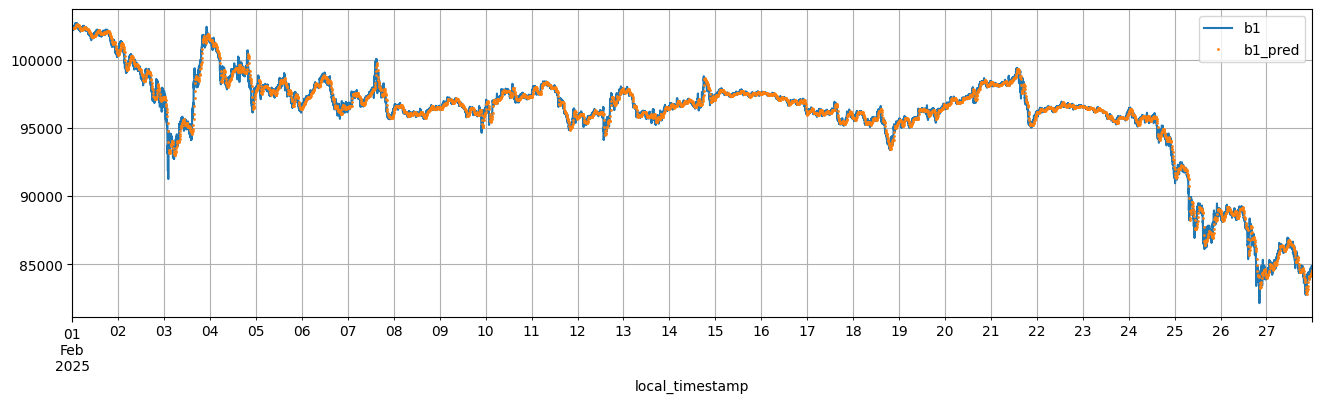

In [12]:
# 予測は基本的に後出しに近い (それはそう)
fig, ax = plt.subplots(figsize=(16, 4))
df_result[["b1"]].plot(ax=ax)
df_result[["b1_pred"]].resample(f"{pred_steps}min").first().shift().plot(ax=ax, ls="", marker=".", ms=2)
# plt.xlim(df_result.index[0], df_result.index[10000])
plt.grid(which="both")

# 手数料・想定手数料を変えてバックテスト

In [13]:
class OrderBot:
    def __init__(self, df_result: pd.DataFrame, model_fee=0.00055):
        self.df = df_result         # b1, a1, b1_pred, a1_pred を含む
        self.model_fee = model_fee  # 「ボットが想定する」手数料．基本的に実際の手数料より多めに見積もるべき

    def order(self, t, state: list) -> tuple[str, int, float]:
        usdt, Q, P, limits = state  # 毎時刻，現在の所持金usdt，建玉数量Q，平均建玉価格P，指値limits情報を得る (実際の取引に似せて)
        # order_type, price: バックテストコードが将来的に指値に対応するためのもの．今回は成行なので適当で構わない
        order_type = "Market"   # Market | Limit
        price = 0               # 成行では何でも良い (ダミー)

        df_t = self.df.loc[t]
        pos = ASK if Q > 0 else BID if Q < 0 else STAY  # 現在のポジション方向

        # 予測値と現在のポジションから期待利益が最大になる行動を決定
        order_t = decide_order(df_t.b1, df_t.a1, df_t.b1_pred, df_t.a1_pred, pos, self.model_fee)[0]
        if order_t == BID:      # 下落予測
            if   Q < 0: qty_x1000 = 0   # 既に売り建玉があれば何もしない
            elif Q > 0: qty_x1000 = -2  # 既に買い建玉があればドテン
            else:       qty_x1000 = -1  # 建玉0なら新規売り
        elif order_t == ASK:    # 上昇予測
            if   Q < 0: qty_x1000 = 2
            elif Q > 0: qty_x1000 = 0
            else:       qty_x1000 = 1
        else:                   # 変化無し予測: 決済のみ
            if   Q < 0: qty_x1000 = 1
            elif Q > 0: qty_x1000 = -1
            else:       qty_x1000 = 0
        return order_type, qty_x1000, price

def validation(df_result: pd.DataFrame, pred_steps=10, fee=0.00055, model_fee=0.00055):
    # バックテスト
    df_steps = df_result.resample(f"{pred_steps}min").first()
    order_func = OrderBot(df_steps, model_fee).order
    df_bt = backtest.backtest(df_result["b1"], df_result["a1"], order_func, df_steps.index[0], df_steps.index[-1], freq=f"{pred_steps}min", fee_market=fee)

    # プロット
    fig, axes = plt.subplots(4, 1, figsize=(16, 8))
    df_bt[["USDT"]].plot(ax=axes[0])    # 資産推移

    # 価格(b1)，予測値，売買
    df_bt[["b1"]].plot(ax=axes[1])
    df_result[["b1_pred"]].resample(f"{pred_steps}min").first().shift().plot(ax=axes[1], ls="", marker=".", ms=2)
    df_bt.loc[df_bt["q"]>0,"a1"].plot(ax=axes[1], ls="", marker="^", ms=1, color="g") if any(df_bt["q"]>0) else None
    df_bt.loc[df_bt["q"]<0,"b1"].plot(ax=axes[1], ls="", marker="v", ms=1, color="r") if any(df_bt["q"]<0) else None
    axes[1].legend(["b1", "b1_pred", "buy", "sell"], loc="lower right")

    # ポジション
    df_bt[["Q", "q"]].plot(ax=axes[2])
    axes[2].legend(["Qty", "ΔQty"])

    # 変分自由エネルギー
    df_result[["VFE", "complexity"]].plot(ax=axes[3], alpha=1)
    # axes[3].set_ylim(0, 1)

    for i in range(4):
        axes[i].grid(which="both")
    # plt.tight_layout()
    return df_bt

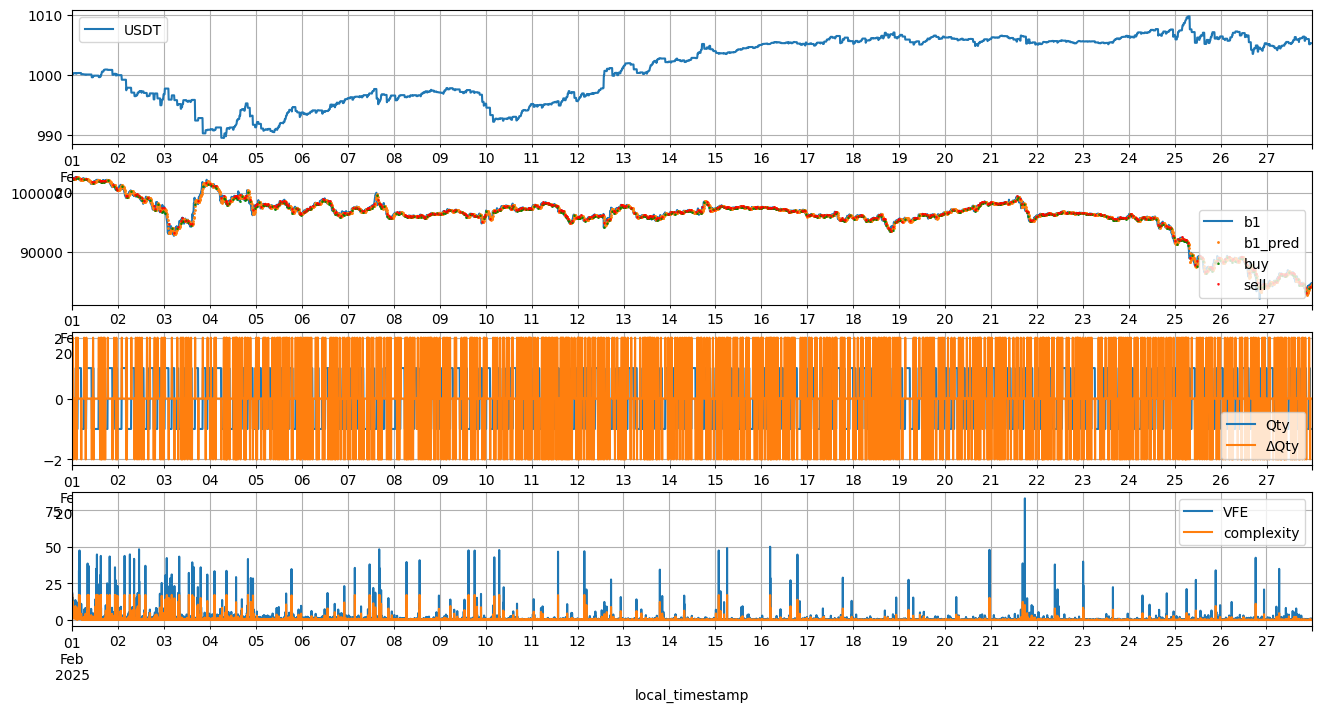

In [14]:
# 手数料0ならかなり安定して増える
df_bt = validation(df_result, pred_steps, fee=0, model_fee=0)

In [15]:
df_bt

,b1,a1,OrderType,q,p,USDT,Q,P
2025-02-01 00:00:00,NaN,NaN,,0,NaN,1000.0000,0,NaN
2025-02-01 00:10:00,102448.8,102448.9,Market,-1,102448.8,1000.0000,-1,102448.8
2025-02-01 00:20:00,102302.1,102302.2,Market,2,102302.2,1000.1466,1,102302.2
2025-02-01 00:30:00,102199.9,102200.0,Market,0,102199.9,1000.1466,1,102302.2
2025-02-01 00:40:00,102414.4,102414.5,Market,-2,102414.4,1000.2588,-1,102414.4
...,...,...,...,...,...,...,...,...
2025-02-27 23:10:00,84414.0,84414.1,Market,0,84414.0,1005.2430,-1,84195.6
2025-02-27 23:20:00,84627.7,84627.8,Market,0,84627.7,1005.2430,-1,84195.6
2025-02-27 23:30:00,84571.4,84571.5,Market,0,84571.4,1005.2430,-1,84195.6
2025-02-27 23:40:00,84808.0,84808.1,Market,0,84808.0,1005.2430,-1,84195.6


In [16]:
df_bt["q"].value_counts()   # 注文数量分布

q
 0    2781
 2     544
-2     542
-1      13
 1       8
Name: count, dtype: int64

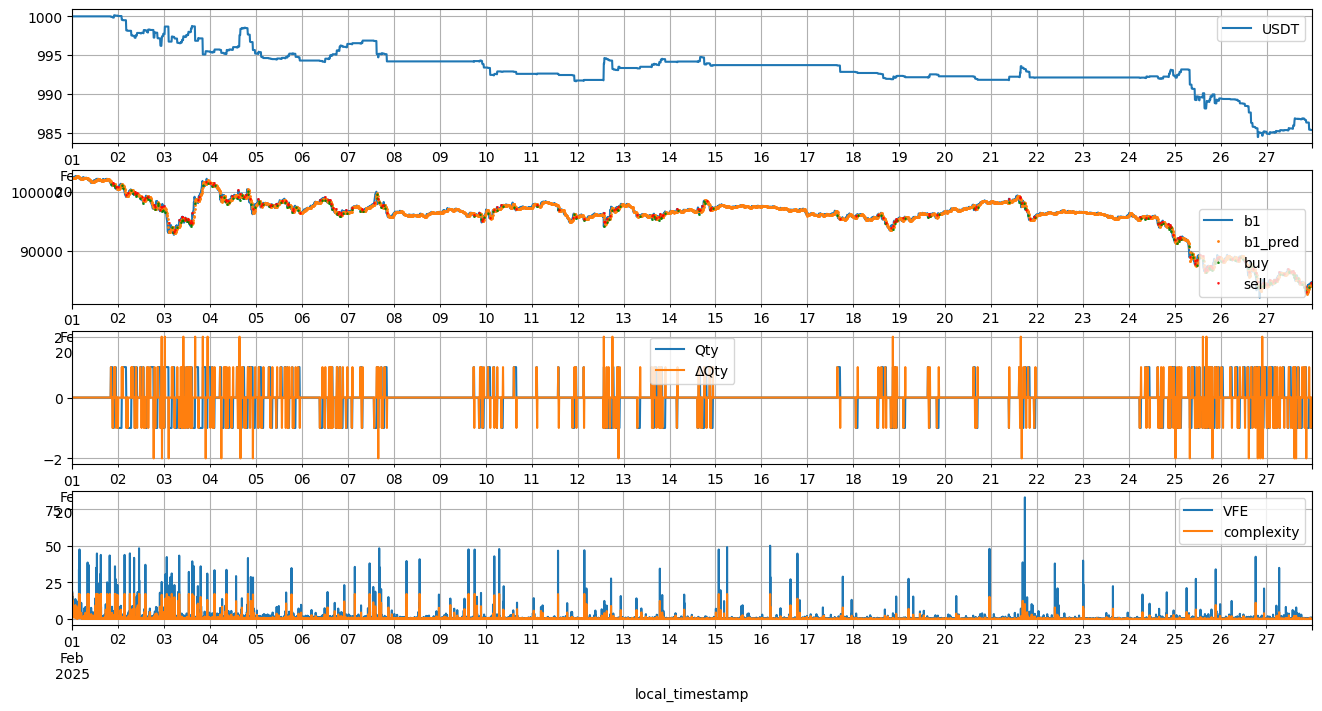

In [17]:
# 手数料ありだと苦しい
df_bt = validation(df_result, pred_steps, fee=0.00055, model_fee=0.0015)

# TLOB 実験（tardis 1分足 / FEP 直接比較）

**目的**: 既存のFEPベース実験と同じ *tardis* の1分足 LOB 入力（`FEATURES = 4 * LOB_DEPTH`）・同じラベル生成規則（予測ホライズン = `pred_steps` 分）で、
論文 **TLOB**（Dual Attention: 時系列軸と特徴軸の双方に自己注意 + BiN 正規化 + MLPMix）を実装・学習し、性能を比較する。

- 参照: TLOB 論文（Berti & Kasneci, 2025）および公開実装の設計要点  
  - Dual Attention（時間→特徴の順で Self-Attention）  
  - Bilinear Normalization（BiN）で時系列軸 / 特徴軸の統計を併用（Tran et al., 2020/2021）  
  - FFN は **MLPLOB**（= 時間軸 MLP + 特徴軸 MLP）に置換  
  - 入力は形状 `[batch, seq_len, num_features]`、出力 3 クラス（Down/Stay/Up）

> **実行順**: 既存セルで `df_ss` / `df_test` / `B1_INDEX` / `A1_INDEX` / `FEATURES` / `lookback` / `pred_steps` が定義済みであることを前提にしています。

In [18]:
# === TLOB アーキテクチャ実装 =====================================================
# 仕様: 論文の記述を忠実に踏まえつつ、PyTorchで自己完結に実装（依存追加なし）。
# - 入力: x ∈ R[B, T, D]  (T=lookback, D=FEATURES)
# - BiN（Bilinear Normalization）: 時系列軸・特徴軸それぞれの標準化を算出し，学習可能重みで線形合成
# - Dual Self-Attention: Temporal Self-Attn (tokens=T, embed=d_model) → Spatial Self-Attn (tokens=D, embed=d_model)
# - MLPLOB: 特徴軸 MLP + 時間軸 MLP（順不同で加算）
# - 出力: 3-class logits

from torch import nn
import torch
from einops import rearrange
import math

class MLP(nn.Module):
    def __init__(self, 
                 start_dim: int,
                 hidden_dim: int,
                 final_dim: int
                 ) -> None:
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(final_dim)
        self.fc = nn.Linear(start_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, final_dim)
        self.gelu = nn.GELU()
        
    def forward(self, x):
        residual = x
        x = self.fc(x)
        x = self.gelu(x)
        x = self.fc2(x)
        if x.shape[2] == residual.shape[2]:
            x = x + residual
        x = self.layer_norm(x)
        x = self.gelu(x)
        return x
    
class ComputeQKV(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.q = nn.Linear(hidden_dim, hidden_dim*num_heads)
        self.k = nn.Linear(hidden_dim, hidden_dim*num_heads)
        self.v = nn.Linear(hidden_dim, hidden_dim*num_heads)
        
    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        return q, k, v

class TransformerLayer(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, final_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.norm = nn.LayerNorm(hidden_dim)
        self.qkv = ComputeQKV(hidden_dim, num_heads)
        self.attention = nn.MultiheadAttention(hidden_dim*num_heads, num_heads, batch_first=True, device=DEVICE)
        self.mlp = MLP(hidden_dim, hidden_dim*4, final_dim)
        self.w0 = nn.Linear(hidden_dim*num_heads, hidden_dim)
        
    def forward(self, x):
        res = x
        q, k, v = self.qkv(x)
        x, att = self.attention(q, k, v, average_attn_weights=False, need_weights=True)
        x = self.w0(x)
        x = x + res
        x = self.norm(x)
        x = self.mlp(x)
        if x.shape[-1] == res.shape[-1]:
            x = x + res
        return x, att

def sinusoidal_positional_embedding(token_sequence_size, token_embedding_dim, n=10000.0):

    if token_embedding_dim % 2 != 0:
        raise ValueError("Sinusoidal positional embedding cannot apply to odd token embedding dim (got dim={:d})".format(token_embedding_dim))

    T = token_sequence_size
    d = token_embedding_dim

    positions = torch.arange(0, T).unsqueeze_(1)
    embeddings = torch.zeros(T, d)

    denominators = torch.pow(n, 2*torch.arange(0, d//2)/d) # 10000^(2i/d_model), i is the index of embedding
    embeddings[:, 0::2] = torch.sin(positions/denominators) # sin(pos/10000^(2i/d_model))
    embeddings[:, 1::2] = torch.cos(positions/denominators) # cos(pos/10000^(2i/d_model))

    return embeddings.to(DEVICE, non_blocking=True)

class BiN(nn.Module):
    """
    Bi-directional Normalization layer for inputs shaped [B, d1, t1].
      - Normalize along time (per feature channel)  -> X2
      - Normalize along feature (per time step)     -> X1
      - Affine transform each, then mix: y1*X1 + y2*X2

    Args:
        d1 (int): number of feature channels
        t1 (int): sequence length
        eps (float): numerical epsilon used in variance/std
        y_init (float): initial value for the mixing weights y1,y2 (positive)
    """
    def __init__(self, d1: int, t1: int, eps: float = 1e-4, y_init: float = 0.5):
        super().__init__()
        self.d1 = d1
        self.t1 = t1
        self.eps = eps

        # Affine params for "feature-wise" transform (applied after time-norm Z2): shape [1, d1, 1]
        self.gamma_f = nn.Parameter(torch.ones(1, d1, 1))
        self.beta_f  = nn.Parameter(torch.zeros(1, d1, 1))

        # Affine params for "time-wise" transform (applied after feature-norm Z1): shape [1, 1, t1]
        self.gamma_t = nn.Parameter(torch.ones(1, 1, t1))
        self.beta_t  = nn.Parameter(torch.zeros(1, 1, t1))

        # Positive mixing weights via softplus to avoid negative values
        # softplus^{-1}(y_init) = log(exp(y_init)-1)
        inv_softplus = torch.log(torch.expm1(torch.tensor(y_init)))
        self.raw_y1 = nn.Parameter(inv_softplus.clone())
        self.raw_y2 = nn.Parameter(inv_softplus.clone())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: Tensor of shape [B, d1, t1]
        """
        assert x.dim() == 3, f"BiN expects a 3D tensor [B, d1, t1], got {x.shape}"
        B, D, T = x.shape
        if D != self.d1 or T != self.t1:
            raise ValueError(f"Input shape mismatch: got [B,{D},{T}], expected [B,{self.d1},{self.t1}]")

        # --- Time-direction normalization (per feature channel) ---
        # mean/std over time dimension
        mean_t = x.mean(dim=2, keepdim=True)                                    # [B, d1, 1]
        var_t  = x.var(dim=2, keepdim=True, unbiased=False)                      # [B, d1, 1]
        std_t  = torch.sqrt(var_t + self.eps)                                    # [B, d1, 1]
        Z2     = (x - mean_t) / std_t                                            # [B, d1, t1]
        X2     = self.gamma_f * Z2 + self.beta_f                                  # broadcast to [B, d1, t1]

        # --- Feature-direction normalization (per time step) ---
        # mean/std over feature dimension
        mean_f = x.mean(dim=1, keepdim=True)                                     # [B, 1, t1]
        var_f  = x.var(dim=1, keepdim=True, unbiased=False)                      # [B, 1, t1]
        std_f  = torch.sqrt(var_f + self.eps)                                    # [B, 1, t1]
        Z1     = (x - mean_f) / std_f                                            # [B, d1, t1]
        X1     = self.gamma_t * Z1 + self.beta_t                                  # broadcast to [B, d1, t1]

        # Positive mixing weights
        y1 = F.softplus(self.raw_y1) + self.eps   # scalar > 0
        y2 = F.softplus(self.raw_y2) + self.eps   # scalar > 0

        return y1 * X1 + y2 * X2

# https://github.com/LeonardoBerti00/TLOB/blob/main/models/tlob.py
class OriginalTLOB(nn.Module):
    """
    TLOB: Time- & Feature-axis alternating Transformer for sequence classification.

    入力形状:
        x: [B, S, F]  (B: バッチ, S: シーケンス長, F: 特徴数)

    処理の流れ(概要):
        1) BiN で [B, F, S] 方向の正規化（特徴/時間の両軸）→ [B, S, F] に戻す
        2) 線形埋め込みで F -> H (hidden_dim)
        3) 位置埋め込み(サイン波 or 学習可能)を加算
        4) TransformerLayer を交互に適用
           - 偶数番目: 最終次元=H として「時間方向の列（S）を token」とみなす
           - 奇数番目: 最終次元=S として「特徴方向の列（H）を token」とみなす
           最終ペアのみ H と S をそれぞれ 1/4 に縮小
        5) [B, S/4, H/4] をフラット化 → MLP で 3 クラスへ

    重要:
        - hidden_dim と seq_size は 4 で割り切れることを前提（最後に //4 に縮小）
    """

    def __init__(
        self,
        hidden_dim: int,
        num_layers: int,
        seq_size: int,
        num_features: int,
        num_heads: int,
        is_sin_emb: bool,
    ) -> None:
        super().__init__()

        if hidden_dim % 4 != 0 or seq_size % 4 != 0:
            raise ValueError(
                f"`hidden_dim` と `seq_size` は 4 で割り切れる必要があります。"
                f" got hidden_dim={hidden_dim}, seq_size={seq_size}"
            )

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_size = seq_size
        self.num_heads = num_heads

        # 1) 前処理: BiN 正規化（[B, F, S] を想定）
        self.norm_layer = BiN(num_features, seq_size)

        # 2) 特徴埋め込み: F -> H（この後は [B, S, H]）
        self.emb_layer = nn.Linear(num_features, hidden_dim)

        # 3) 位置埋め込み ([1, S, H])
        if is_sin_emb:
            pe = self._build_sinusoidal_pe(seq_size, hidden_dim)  # [1, S, H]
            self.register_buffer("pos_encoder", pe, persistent=False)
            self.pos_is_buffer = True
        else:
            self.pos_encoder = nn.Parameter(torch.randn(1, seq_size, hidden_dim))
            self.pos_is_buffer = False

        # 4) 交互 Transformer ブロックの構築
        #    各層 i で 2 つずつ: (feature-side), (temporal-side)
        #    最終ペアのみ出力次元を /4
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            last = (i == num_layers - 1)

            # feature 側 (最後の次元が H)
            out_h = hidden_dim // 4 if last else hidden_dim
            self.layers.append(TransformerLayer(hidden_dim, num_heads, out_h))

            # temporal 側 (最後の次元が S)
            out_s = seq_size // 4 if last else seq_size
            self.layers.append(TransformerLayer(seq_size, num_heads, out_s))

        # 5) 最終 MLP（[B, (S/4 * H/4)] -> [B, 3]）
        total_dim = (hidden_dim // 4) * (seq_size // 4)
        mlp = []
        while total_dim > 128:
            mlp += [nn.Linear(total_dim, total_dim // 4), nn.GELU()]
            total_dim //= 4
        mlp += [nn.Linear(total_dim, 3)]
        self.final_mlp = nn.Sequential(*mlp)

        # optional: 直近のアテンションを外から参照したい場合に使う
        self.last_attentions = []  # list[Tensor]

    @staticmethod
    def _build_sinusoidal_pe(seq_len: int, dim: int) -> torch.Tensor:
        """
        標準的なサイン/コサイン位置埋め込みを返す: [1, S, H]
        """
        pe = torch.zeros(seq_len, dim)  # [S, H]
        position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)  # [S, 1]
        div_term = torch.exp(
            torch.arange(0, dim, 2, dtype=torch.float32) * (-math.log(10000.0) / dim)
        )  # [H/2]
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # [1, S, H]

    def forward(self, x: torch.Tensor, store_att: bool = False) -> torch.Tensor:
        """
        x: [B, S, F]
        return: [B, 3]  (ロジット)
        """
        if x.dim() != 3 or x.shape[1] != self.seq_size:
            raise ValueError(
                f"入力は [B, S, F] で、S={self.seq_size} 固定を想定しています。got {tuple(x.shape)}"
            )

        B, S, F = x.shape

        # [B, S, F] -> [B, F, S] -> BiN -> [B, F, S] -> [B, S, F]
        x = rearrange(x, "b s f -> b f s")
        x = self.norm_layer(x)
        x = rearrange(x, "b f s -> b s f")

        # F -> H
        x = self.emb_layer(x)  # [B, S, H]

        # 位置埋め込み
        # buffer/parameter どちらでもブロードキャストで [B, S, H] に足し込める
        x = x + self.pos_encoder

        # 交互 Transformer 適用
        self.last_attentions = []  # リセット
        for layer in self.layers:
            # 入力は常に [B, tokens, d_model]
            x, att = layer(x)         # 出力 [B, tokens, final_dim], att: 注意重み
            if store_att:
                # 勾配は基本不要なので detach して保存
                self.last_attentions.append(att.detach())
            # 軸を交互に入れ替え: [B, tokens, d_model] -> [B, d_model, tokens]
            x = x.permute(0, 2, 1)

        # ここで x の形は [B, H/4, S/4] になっている（最後の permute 済み）
        # [B, S/4, H/4] に戻してからフラット化、でもどちらでも面積は同じ。
        x = rearrange(x, "b f s -> b (s f)")

        # 最終 MLP
        x = self.final_mlp(x)  # [B, 3]
        return x

In [19]:
# === データ前処理・データセット生成 =================================================
import numpy as np
import pandas as pd
from dataclasses import dataclass
import torch
from torch import Tensor
from typing import Tuple

@dataclass
class LabelingConfig:
    horizon_steps: int             # 予測ホライズン H（ステップ数）
    smooth_len: int = 5            # 平滑化窓 W（H と独立）
    epsilon_mode: str = "avg_spread"  # "avg_spread"（割合閾値） or "zero"（閾値0） or "nonzero"（閾値0.002）
    epsilon_scale: float = 0.5        # "avg_spread" のときの倍率（データセット全体で一定）


def make_lob_window_dataset(
    df: pd.DataFrame,
    feature_count: int,
    lookback: int,
    b1_index: int,
    a1_index: int,
    labeling: LabelingConfig,
) -> Tuple[Tensor, Tensor, np.ndarray]:
    """
    TLOB 第4節の目的変数:
      - m_past(t)  = 過去 W 本の mid の平均
      - m_future(t)= 将来側で (t+H の直後) から W 本の mid の平均
      - 変化率 Δ  = (m_future - m_past) / m_past   （割合）
      - ラベル    = Δ >  ε : Up(2), Δ < -ε : Down(0), それ以外 : Stay(1)

    df: 1分足の LOB（先頭 feature_count 列を入力特徴として使用）
    return:
      X: [N, lookback, feature_count]
      y: [N] （0=Down, 1=Stay, 2=Up）
      t: 各サンプルの終端時刻 index（np.datetime64）
    """
    assert df.shape[1] >= feature_count, "df 先頭に LOB 特徴が並んでいる必要があります"

    # --- 入力特徴と mid / spread の作成 ---
    values = df.iloc[:, :feature_count].values.astype(np.float32)
    b1 = values[:, b1_index]
    a1 = values[:, a1_index]
    mid = (b1 + a1) * 0.5
    spread = (a1 - b1)

    # --- ラベリング・ハイパラ ---
    H = int(labeling.horizon_steps)
    W = max(1, int(labeling.smooth_len))

    # --- 閾値 ε（割合）。"avg_spread" はデータセット一定の割合閾値 ---
    #     Δ は割合なので、ε も割合で用意する
    avg_spread = float(np.nanmean(spread)) if np.isfinite(spread).all() else float(pd.Series(spread).mean())

    # --- 走査範囲（境界安全）---
    # 入力窓: [i-lookback+1, i]
    # m_past: 過去 W 本が必要 → i >= W-1
    # m_future: [i+H+1, i+H+W] を使う → i <= len(mid) - (H+W) - 1
    start_i = max(lookback - 1, W - 1)
    end_i_exclusive = len(df) - (H + W)  # range の終端（非包含）

    X_list, y_list, t_list = [], [], []

    for i in range(start_i, end_i_exclusive):
        # 平滑化ミッド（過去・未来）
        m_past = float(np.mean(mid[i - W + 1 : i + 1]))
        m_fut  = float(np.mean(mid[i + H + 1 : i + H + W + 1]))

        # 割合変化 Δ
        delta = (m_fut - m_past) / m_past

        if labeling.epsilon_mode == "avg_spread":
            eps = (avg_spread / max(1e-12, m_past)) * float(labeling.epsilon_scale)
        elif labeling.epsilon_mode == "zero":
            eps = 0.0
        elif labeling.epsilon_mode == "nonzero":
            eps = 0.002
        else:
            raise ValueError(f"unknown epsilon_mode: {labeling.epsilon_mode}")

        # 3クラス 0/1/2
        if   delta >=  eps: y = 2  # Up
        elif delta <  -eps: y = 0  # Down
        else:               y = 1  # Stay

        # 入力窓の切り出し
        X = values[i - lookback + 1 : i + 1, :]
        X_list.append(X)
        y_list.append(y)
        t_list.append(df.index[i])

    # --- Tensor 化 ---
    X = torch.tensor(np.stack(X_list), dtype=torch.float32, device=DEVICE)
    y = torch.tensor(np.array(y_list), dtype=torch.long, device=DEVICE)
    t = np.array(t_list, dtype="datetime64[ns]")
    return X, y, t

def train_val_split_by_time(X: Tensor, y: Tensor, t: np.ndarray, val_ratio: float = 0.2):
    assert len(X) == len(y) == len(t)
    n = len(X)
    k = max(1, int(n * (1 - val_ratio)))
    return (X[:k], y[:k], t[:k]), (X[k:], y[k:], t[k:])

def macro_f1(y_true: np.ndarray, y_pred: np.ndarray, n_classes: int = 3) -> float:
    f1s = []
    for c in range(n_classes):
        tp = ((y_true == c) & (y_pred == c)).sum()
        fp = ((y_true != c) & (y_pred == c)).sum()
        fn = ((y_true == c) & (y_pred != c)).sum()
        if tp + fp + fn == 0:
            f1s.append(0.0)
        else:
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1s.append( 0.0 if (precision + recall) == 0 else 2 * precision * recall / (precision + recall) )
    return float(np.mean(f1s))

In [20]:
from copy import deepcopy
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

@torch.no_grad()
def evaluate(model: nn.Module, X: torch.Tensor, y: torch.Tensor, batch_size: int = 256):
    model.eval()
    preds = []
    for i in range(0, len(X), batch_size):
        xb = X[i:i+batch_size]
        logits = model(xb)                # [B, 3]
        preds.append(logits.argmax(-1).cpu().numpy())
    y_pred = np.concatenate(preds) if preds else np.empty((0,), dtype=int)
    y_true = y.cpu().numpy()
    acc = float((y_pred == y_true).mean()) if len(y_true) else float("nan")
    f1  = macro_f1(y_true, y_pred, n_classes=3) if len(y_true) else float("nan")
    return {"acc": acc, "macro_f1": f1}


def train_tlob(
    df: pd.DataFrame,
    feature_count: int,
    lookback: int,
    b1_index: int,
    a1_index: int,
    horizon_steps: int,
    eps_mode: str = "avg_spread",
    eps_scale: float = 0.5,
    smooth_len: int = 5,          # 第4節: 平滑化窓 W
    d_model: int = 128,
    n_heads: int = 4,
    n_layers: int = 2,
    is_sin_emb: bool = True,      # 位置埋め込み
    # 下2つは互換のため残すが未使用（OriginalTLOB内部で完結）
    mlp_hidden: int = 256,
    dropout: float = 0.1,
    epochs: int = 5,
    batch_size: int = 256,
    lr: float = 2e-4,
    val_ratio: float = 0.2,
    seed: int = 42,
):
    torch.manual_seed(seed); np.random.seed(seed)

    labeling = LabelingConfig(
        horizon_steps=horizon_steps,
        smooth_len=smooth_len,
        epsilon_mode=eps_mode,
        epsilon_scale=eps_scale,
    )

    X, y, t = make_lob_window_dataset(df, feature_count, lookback, b1_index, a1_index, labeling)
    (Xtr, ytr, ttr), (Xva, yva, tva) = train_val_split_by_time(X, y, t, val_ratio=val_ratio)

    device = X.device
    model = OriginalTLOB(
        hidden_dim=d_model,
        num_layers=n_layers,
        seq_size=lookback,
        num_features=feature_count,
        num_heads=n_heads,
        is_sin_emb=is_sin_emb,
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, epochs))

    best = {"epoch": -1, "score": -1.0, "state": None}

    for ep in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(len(Xtr), device=device)
        total = 0.0
        for i in range(0, len(Xtr), batch_size):
            idx = perm[i:i+batch_size]
            xb, yb = Xtr[idx], ytr[idx]
            logits = model(xb)                 # [B, 3]
            loss = F.cross_entropy(logits, yb)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            total += float(loss.detach().cpu()) * len(idx)

        sched.step()

        val = evaluate(model, Xva, yva, batch_size=batch_size)
        score = val["macro_f1"]
        if np.isfinite(score) and score > best["score"]:
            best = {"epoch": ep, "score": score, "state": deepcopy(model.state_dict())}

        print(f"[{ep:02d}] train_loss={total/max(1,len(Xtr)):.4f}  val_acc={val['acc']:.4f}  val_f1={val['macro_f1']:.4f}")

    if best["state"] is not None:
        model.load_state_dict(best["state"])

    return model, {
        "val_best_epoch": best["epoch"],
        "val_best_macro_f1": best["score"],
        "val_metrics_final": evaluate(model, Xva, yva, batch_size=batch_size),
    }

In [21]:
lookback = 100

# 学習
model_tlob, val_info = train_tlob(
    df=df_ss,
    feature_count=int(FEATURES),
    lookback=int(lookback),
    b1_index=int(B1_INDEX),
    a1_index=int(A1_INDEX),
    horizon_steps=int(pred_steps),
    eps_mode="avg_spread",
    eps_scale=0.5,
    smooth_len=5,
    d_model=128, n_heads=4, mlp_hidden=256, n_layers=2, dropout=0.1,
    epochs=5, batch_size=256, lr=2e-4, val_ratio=0.2, seed=42
)
print("Validation(best):", val_info)

[01] train_loss=0.6973  val_acc=0.5465  val_f1=0.3143
[02] train_loss=0.6732  val_acc=0.5887  val_f1=0.3922
[03] train_loss=0.6604  val_acc=0.5732  val_f1=0.3815
[04] train_loss=0.6306  val_acc=0.5647  val_f1=0.3757
[05] train_loss=0.5800  val_acc=0.5616  val_f1=0.3739
Validation(best): {'val_best_epoch': 2, 'val_best_macro_f1': 0.3922374429158036, 'val_metrics_final': {'acc': 0.5886584342404988, 'macro_f1': 0.3922374429158036}}


In [22]:
@torch.inference_mode()
def predict_in_batches(model: torch.nn.Module, X: torch.Tensor, batch_size: int = 2048) -> np.ndarray:
    model.eval()
    device = next(model.parameters()).device
    preds = []
    for i in range(0, len(X), batch_size):
        print(f"Predicting batch {i//batch_size + 1} / {((len(X)-1)//batch_size) + 1}", end="\r")
        xb = X[i:i+batch_size].to(device, non_blocking=True)  # ← バッチだけGPUへ
        logits = model(xb)                                     # [B, 3]
        preds.append(logits.argmax(-1).cpu().numpy())
    return np.concatenate(preds) if preds else np.empty((0,), dtype=int)

# テスト全体で推論（ラベルも同時作成）
labeling = LabelingConfig(
    horizon_steps=int(pred_steps),
    smooth_len=5,             # 学習時と同じ W
    epsilon_mode="avg_spread",
    epsilon_scale=0.5,
)
X_all, y_all, t_all = make_lob_window_dataset(
    df_ss, int(FEATURES), int(lookback), int(B1_INDEX), int(A1_INDEX), labeling
)

y_true_all = y_all.cpu().numpy()
y_pred_all = predict_in_batches(model_tlob, X_all, batch_size=2048)

acc_all = float((y_pred_all == y_true_all).mean()) if len(y_true_all) else float("nan")
f1_all  = macro_f1(y_true_all, y_pred_all, n_classes=3) if len(y_true_all) else float("nan")
print(f"[TLOB @ all test windows]  acc={acc_all:.4f}  macro_f1={f1_all:.4f}  (N={len(y_true_all)})")

[TLOB @ all test windows]  acc=0.5995  macro_f1=0.3997  (N=83406)


In [23]:
(Xtr, ytr, ttr), (Xva, yva, tva) = train_val_split_by_time(X_all, y_all, t_all, val_ratio=0.2)
y_true_valid = yva.cpu().numpy()
y_pred_valid = predict_in_batches(model_tlob, Xva, batch_size=2048)

acc_valid = float((y_pred_valid == y_true_valid).mean()) if len(y_true_valid) else float("nan")
f1_valid  = macro_f1(y_true_valid, y_pred_valid, n_classes=3) if len(y_true_valid) else float("nan")
print(f"[TLOB @ valid windows]     acc={acc_valid:.4f}  macro_f1={f1_valid:.4f}  (N={len(y_true_valid)})")

[TLOB @ valid windows]     acc=0.5887  macro_f1=0.3922  (N=16682)


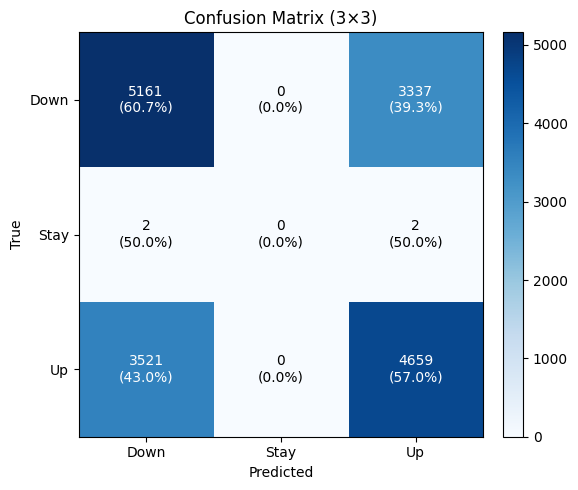

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# y_true_all, y_pred_all をそのまま使える想定
# 例: y_true_all = y_all.cpu().numpy(); y_pred_all = logits_all.argmax(-1).cpu().numpy()

def plot_confusion_matrix(y_true, y_pred, class_names=("Down","Stay","Up"), normalize="row"):
    """
    normalize: "row"（行方向％）, "all"（全体％）, None（生のカウント）
    """
    C = len(class_names)
    cm = np.zeros((C, C), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(range(C)); ax.set_yticks(range(C))
    ax.set_xticklabels(class_names, rotation=0)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix (3×3)")

    # 割合表示用
    if normalize == "row":
        denom = cm.sum(axis=1, keepdims=True).clip(min=1)
        cm_pct = cm / denom
    elif normalize == "all":
        total = max(1, cm.sum())
        cm_pct = cm / total
    else:
        cm_pct = None

    # セル内アノテーション（カウント & ％）
    vmax = cm.max() if cm.size else 1
    for i in range(C):
        for j in range(C):
            text = f"{cm[i, j]}"
            if cm_pct is not None:
                text += f"\n({cm_pct[i, j]*100:.1f}%)"
            ax.text(j, i, text,
                    ha="center", va="center",
                    color="white" if cm[i, j] > vmax/2 else "black",
                    fontsize=10)

    plt.tight_layout()
    plt.show()
    return cm

# 使い方
# cm = plot_confusion_matrix(y_true_all, y_pred_all, class_names=("Down","Stay","Up"), normalize="row")
cm = plot_confusion_matrix(y_true_valid, y_pred_valid, class_names=("Down","Stay","Up"), normalize="row")


In [25]:
lookback = 100

# 学習
model_tlob, val_info = train_tlob(
    df=df_ss,
    feature_count=int(FEATURES),
    lookback=int(lookback),
    b1_index=int(B1_INDEX),
    a1_index=int(A1_INDEX),
    horizon_steps=int(pred_steps),
    eps_mode="avg_spread",
    eps_scale=1.0,
    smooth_len=5,
    d_model=128, n_heads=4, mlp_hidden=256, n_layers=2, dropout=0.1,
    epochs=5, batch_size=256, lr=2e-4, val_ratio=0.2, seed=42
)
print("Validation(best):", val_info)

[01] train_loss=0.6983  val_acc=0.5719  val_f1=0.3671
[02] train_loss=0.6755  val_acc=0.5803  val_f1=0.3870
[03] train_loss=0.6630  val_acc=0.5682  val_f1=0.3784
[04] train_loss=0.6425  val_acc=0.5649  val_f1=0.3750
[05] train_loss=0.6178  val_acc=0.5610  val_f1=0.3737
Validation(best): {'val_best_epoch': 2, 'val_best_macro_f1': 0.38698677544671306, 'val_metrics_final': {'acc': 0.580326099988011, 'macro_f1': 0.38698677544671306}}


In [26]:
labeling = LabelingConfig(
    horizon_steps=int(pred_steps),
    smooth_len=5,             # 学習時と同じ W
    epsilon_mode="avg_spread",
    epsilon_scale=1.0,
)
X_all, y_all, t_all = make_lob_window_dataset(
    df_ss, int(FEATURES), int(lookback), int(B1_INDEX), int(A1_INDEX), labeling
)

(Xtr, ytr, ttr), (Xva, yva, tva) = train_val_split_by_time(X_all, y_all, t_all, val_ratio=0.2)
y_true_valid = yva.cpu().numpy()
y_pred_valid = predict_in_batches(model_tlob, Xva, batch_size=2048)

acc_valid = float((y_pred_valid == y_true_valid).mean()) if len(y_true_valid) else float("nan")
f1_valid  = macro_f1(y_true_valid, y_pred_valid, n_classes=3) if len(y_true_valid) else float("nan")
print(f"[TLOB @ valid windows]     acc={acc_valid:.4f}  macro_f1={f1_valid:.4f}  (N={len(y_true_valid)})")

[TLOB @ valid windows]     acc=0.5803  macro_f1=0.3870  (N=16682)


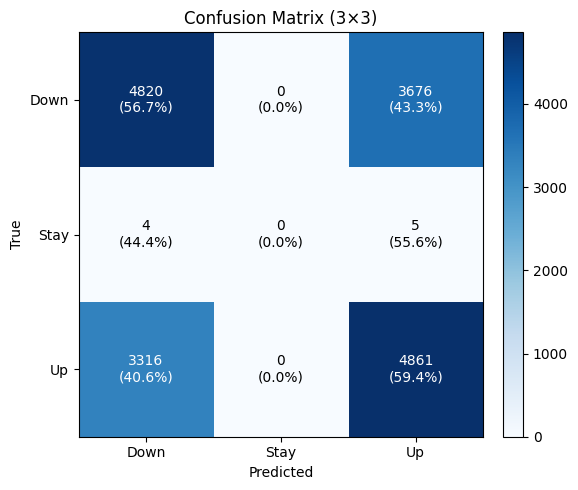

In [27]:
cm = plot_confusion_matrix(y_true_valid, y_pred_valid, class_names=("Down","Stay","Up"), normalize="row")

In [28]:
lookback = 100

# 学習
model_tlob, val_info = train_tlob(
    df=df_ss,
    feature_count=int(FEATURES),
    lookback=int(lookback),
    b1_index=int(B1_INDEX),
    a1_index=int(A1_INDEX),
    horizon_steps=int(pred_steps),
    eps_mode="avg_spread",
    eps_scale=2.0,
    smooth_len=5,
    d_model=128, n_heads=4, mlp_hidden=256, n_layers=2, dropout=0.1,
    epochs=5, batch_size=256, lr=2e-4, val_ratio=0.2, seed=42
)
print("Validation(best):", val_info)

[01] train_loss=0.7019  val_acc=0.5485  val_f1=0.3204
[02] train_loss=0.6785  val_acc=0.5797  val_f1=0.3840
[03] train_loss=0.6666  val_acc=0.5649  val_f1=0.3767
[04] train_loss=0.6400  val_acc=0.5502  val_f1=0.3648
[05] train_loss=0.5957  val_acc=0.5430  val_f1=0.3608
Validation(best): {'val_best_epoch': 2, 'val_best_macro_f1': 0.3839503977177576, 'val_metrics_final': {'acc': 0.5796667066299005, 'macro_f1': 0.3839503977177576}}


[TLOB @ valid windows]     acc=0.5797  macro_f1=0.3840  (N=16682)


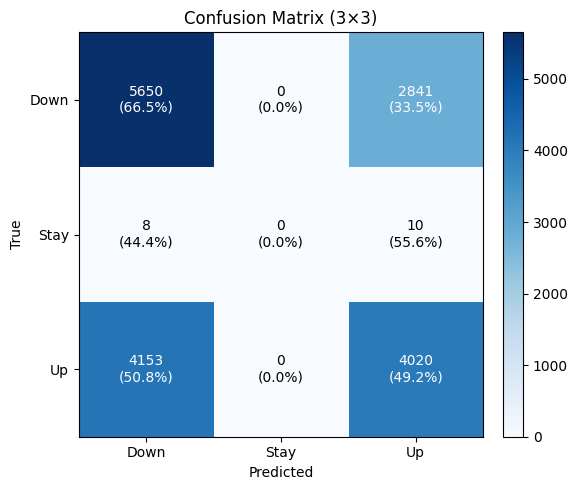

In [29]:
labeling = LabelingConfig(
    horizon_steps=int(pred_steps),
    smooth_len=5,             # 学習時と同じ W
    epsilon_mode="avg_spread",
    epsilon_scale=2.0,
)
X_all, y_all, t_all = make_lob_window_dataset(
    df_ss, int(FEATURES), int(lookback), int(B1_INDEX), int(A1_INDEX), labeling
)

(Xtr, ytr, ttr), (Xva, yva, tva) = train_val_split_by_time(X_all, y_all, t_all, val_ratio=0.2)
y_true_valid = yva.cpu().numpy()
y_pred_valid = predict_in_batches(model_tlob, Xva, batch_size=2048)

acc_valid = float((y_pred_valid == y_true_valid).mean()) if len(y_true_valid) else float("nan")
f1_valid  = macro_f1(y_true_valid, y_pred_valid, n_classes=3) if len(y_true_valid) else float("nan")
print(f"[TLOB @ valid windows]     acc={acc_valid:.4f}  macro_f1={f1_valid:.4f}  (N={len(y_true_valid)})")
cm = plot_confusion_matrix(y_true_valid, y_pred_valid, class_names=("Down","Stay","Up"), normalize="row")

In [30]:
lookback = 100

# 学習
model_tlob, val_info = train_tlob(
    df=df_ss,
    feature_count=int(FEATURES),
    lookback=int(lookback),
    b1_index=int(B1_INDEX),
    a1_index=int(A1_INDEX),
    horizon_steps=int(pred_steps),
    eps_mode="nonzero",
    eps_scale=2.0,
    smooth_len=5,
    d_model=128, n_heads=4, mlp_hidden=256, n_layers=2, dropout=0.1,
    epochs=5, batch_size=256, lr=2e-4, val_ratio=0.2, seed=42
)
print("Validation(best):", val_info)

[01] train_loss=0.7856  val_acc=0.7460  val_f1=0.2848
[02] train_loss=0.7456  val_acc=0.7256  val_f1=0.3330
[03] train_loss=0.6793  val_acc=0.7139  val_f1=0.3536
[04] train_loss=0.5469  val_acc=0.6870  val_f1=0.3678
[05] train_loss=0.4340  val_acc=0.6767  val_f1=0.3768
Validation(best): {'val_best_epoch': 5, 'val_best_macro_f1': 0.37679161362785, 'val_metrics_final': {'acc': 0.676657475122887, 'macro_f1': 0.37679161362785}}


[TLOB @ valid windows]     acc=0.6767  macro_f1=0.3768  (N=16682)


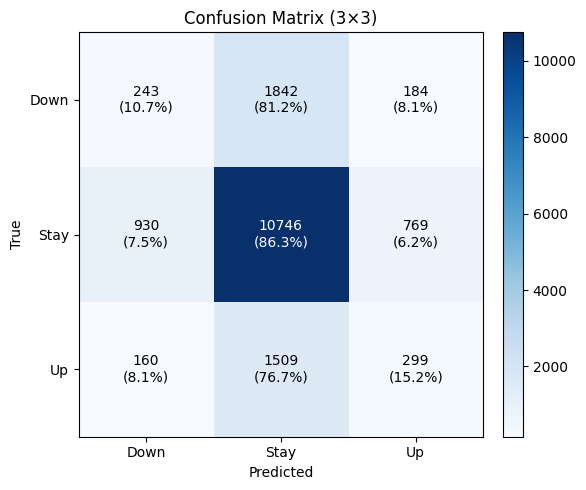

In [31]:
labeling = LabelingConfig(
    horizon_steps=int(pred_steps),
    smooth_len=5,             # 学習時と同じ W
    epsilon_mode="nonzero",
    epsilon_scale=2.0,
)
X_all, y_all, t_all = make_lob_window_dataset(
    df_ss, int(FEATURES), int(lookback), int(B1_INDEX), int(A1_INDEX), labeling
)

(Xtr, ytr, ttr), (Xva, yva, tva) = train_val_split_by_time(X_all, y_all, t_all, val_ratio=0.2)
y_true_valid = yva.cpu().numpy()
y_pred_valid = predict_in_batches(model_tlob, Xva, batch_size=2048)

acc_valid = float((y_pred_valid == y_true_valid).mean()) if len(y_true_valid) else float("nan")
f1_valid  = macro_f1(y_true_valid, y_pred_valid, n_classes=3) if len(y_true_valid) else float("nan")
print(f"[TLOB @ valid windows]     acc={acc_valid:.4f}  macro_f1={f1_valid:.4f}  (N={len(y_true_valid)})")
cm = plot_confusion_matrix(y_true_valid, y_pred_valid, class_names=("Down","Stay","Up"), normalize="row")

In [34]:
lookback = 100

# 学習
model_tlob, val_info = train_tlob(
    df=df_ss,
    feature_count=int(FEATURES),
    lookback=int(lookback),
    b1_index=int(B1_INDEX),
    a1_index=int(A1_INDEX),
    horizon_steps=int(pred_steps),
    eps_mode="nonzero",
    eps_scale=2.0,
    smooth_len=5,
    d_model=256, n_heads=4, mlp_hidden=256, n_layers=2, dropout=0.1,
    epochs=5, batch_size=256, lr=2e-4, val_ratio=0.2, seed=42
)
print("Validation(best):", val_info)

[01] train_loss=0.7848  val_acc=0.7460  val_f1=0.2848
[02] train_loss=0.7628  val_acc=0.7460  val_f1=0.2848
[03] train_loss=0.7448  val_acc=0.7452  val_f1=0.3093
[04] train_loss=0.7214  val_acc=0.7413  val_f1=0.3270
[05] train_loss=0.6893  val_acc=0.7389  val_f1=0.3387
Validation(best): {'val_best_epoch': 5, 'val_best_macro_f1': 0.3386632612484067, 'val_metrics_final': {'acc': 0.7389401750389641, 'macro_f1': 0.3386632612484067}}


[TLOB @ valid windows]     acc=0.7389  macro_f1=0.3387  (N=16682)


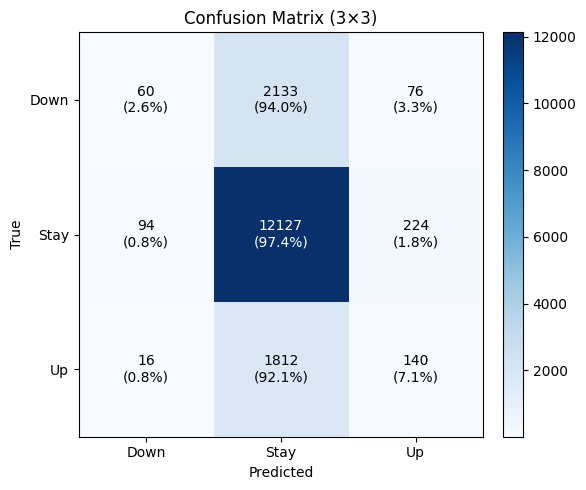

In [35]:
labeling = LabelingConfig(
    horizon_steps=int(pred_steps),
    smooth_len=5,             # 学習時と同じ W
    epsilon_mode="nonzero",
    epsilon_scale=2.0,
)
X_all, y_all, t_all = make_lob_window_dataset(
    df_ss, int(FEATURES), int(lookback), int(B1_INDEX), int(A1_INDEX), labeling
)

(Xtr, ytr, ttr), (Xva, yva, tva) = train_val_split_by_time(X_all, y_all, t_all, val_ratio=0.2)
y_true_valid = yva.cpu().numpy()
y_pred_valid = predict_in_batches(model_tlob, Xva, batch_size=2048)

acc_valid = float((y_pred_valid == y_true_valid).mean()) if len(y_true_valid) else float("nan")
f1_valid  = macro_f1(y_true_valid, y_pred_valid, n_classes=3) if len(y_true_valid) else float("nan")
print(f"[TLOB @ valid windows]     acc={acc_valid:.4f}  macro_f1={f1_valid:.4f}  (N={len(y_true_valid)})")
cm = plot_confusion_matrix(y_true_valid, y_pred_valid, class_names=("Down","Stay","Up"), normalize="row")

In [36]:
lookback = 100

# 学習
model_tlob, val_info = train_tlob(
    df=df_ss,
    feature_count=int(FEATURES),
    lookback=int(lookback),
    b1_index=int(B1_INDEX),
    a1_index=int(A1_INDEX),
    horizon_steps=int(pred_steps),
    eps_mode="nonzero",
    eps_scale=2.0,
    smooth_len=5,
    d_model=256, n_heads=4, mlp_hidden=256, n_layers=4, dropout=0.1,
    epochs=10, batch_size=256, lr=2e-4, val_ratio=0.2, seed=42
)
print("Validation(best):", val_info)

KeyboardInterrupt: 

In [ ]:
labeling = LabelingConfig(
    horizon_steps=int(pred_steps),
    smooth_len=5,             # 学習時と同じ W
    epsilon_mode="nonzero",
    epsilon_scale=2.0,
)
X_all, y_all, t_all = make_lob_window_dataset(
    df_ss, int(FEATURES), int(lookback), int(B1_INDEX), int(A1_INDEX), labeling
)

(Xtr, ytr, ttr), (Xva, yva, tva) = train_val_split_by_time(X_all, y_all, t_all, val_ratio=0.2)
y_true_valid = yva.cpu().numpy()
y_pred_valid = predict_in_batches(model_tlob, Xva, batch_size=2048)

acc_valid = float((y_pred_valid == y_true_valid).mean()) if len(y_true_valid) else float("nan")
f1_valid  = macro_f1(y_true_valid, y_pred_valid, n_classes=3) if len(y_true_valid) else float("nan")
print(f"[TLOB @ valid windows]     acc={acc_valid:.4f}  macro_f1={f1_valid:.4f}  (N={len(y_true_valid)})")
cm = plot_confusion_matrix(y_true_valid, y_pred_valid, class_names=("Down","Stay","Up"), normalize="row")